<a href="https://colab.research.google.com/github/lazysimon/NYCDSA_CapstoneProject/blob/master/movie_eda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [68]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://mirror.its.dal.ca/apache/spark/spark-2.4.4/spark-2.4.4-bin-hadoop2.7.tgz
!tar xvf spark-2.4.4-bin-hadoop2.7.tgz
!pip install -q findspark

spark-2.4.4-bin-hadoop2.7/
spark-2.4.4-bin-hadoop2.7/R/
spark-2.4.4-bin-hadoop2.7/R/lib/
spark-2.4.4-bin-hadoop2.7/R/lib/sparkr.zip
spark-2.4.4-bin-hadoop2.7/R/lib/SparkR/
spark-2.4.4-bin-hadoop2.7/R/lib/SparkR/INDEX
spark-2.4.4-bin-hadoop2.7/R/lib/SparkR/html/
spark-2.4.4-bin-hadoop2.7/R/lib/SparkR/html/R.css
spark-2.4.4-bin-hadoop2.7/R/lib/SparkR/html/00Index.html
spark-2.4.4-bin-hadoop2.7/R/lib/SparkR/help/
spark-2.4.4-bin-hadoop2.7/R/lib/SparkR/help/aliases.rds
spark-2.4.4-bin-hadoop2.7/R/lib/SparkR/help/AnIndex
spark-2.4.4-bin-hadoop2.7/R/lib/SparkR/help/SparkR.rdx
spark-2.4.4-bin-hadoop2.7/R/lib/SparkR/help/SparkR.rdb
spark-2.4.4-bin-hadoop2.7/R/lib/SparkR/help/paths.rds
spark-2.4.4-bin-hadoop2.7/R/lib/SparkR/worker/
spark-2.4.4-bin-hadoop2.7/R/lib/SparkR/worker/worker.R
spark-2.4.4-bin-hadoop2.7/R/lib/SparkR/worker/daemon.R
spark-2.4.4-bin-hadoop2.7/R/lib/SparkR/tests/
spark-2.4.4-bin-hadoop2.7/R/lib/SparkR/tests/testthat/
spark-2.4.4-bin-hadoop2.7/R/lib/SparkR/tests/testthat/te

In [0]:
import numpy as np
import pandas as pd
from urllib.request import urlopen
from numpy import loadtxt

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.4-bin-hadoop2.7"

import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark.sql.functions import UserDefinedFunction, explode, desc
from pyspark.sql.types import StringType, ArrayType
from pyspark.mllib.recommendation import ALS
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [0]:
def read_the_dat(filepath):
    with urlopen(filepath) as raw_data:
        datfileL=pd.DataFrame(l.decode("utf-8").rstrip().split('::') for l in raw_data)
    return datfileL

In [71]:
movie_fname = 'https://raw.githubusercontent.com/lazysimon/NYCDSA_CapstoneProject/master/latest/movies.dat'
movie_df = read_the_dat(movie_fname)
movie_df.columns = ['movieID', 'title', 'genres']
movie_df['movieID'] = movie_df['movieID'].astype(int)
movie_df.head()

,movieID,title,genres
0,8,Edison Kinetoscopic Record of a Sneeze (1894),Documentary|Short
1,10,La sortie des usines Lumière (1895),Documentary|Short
2,12,The Arrival of a Train (1896),Documentary|Short
3,25,The Oxford and Cambridge University Boat Race ...,
4,91,Le manoir du diable (1896),Short|Horror


In [72]:
rating_fname = 'https://raw.githubusercontent.com/lazysimon/NYCDSA_CapstoneProject/master/latest/ratings.dat'
rating_df = read_the_dat(rating_fname)
rating_df.columns = ['userID', 'movieID', 'rating', 'timestamp']
rating_df['userID'] = rating_df['userID'].astype(int)
rating_df['movieID'] = rating_df['movieID'].astype(int)
rating_df['rating'] = rating_df['rating'].astype(int)
rating_df['timestamp'] = rating_df['timestamp'].astype(int)
rating_df.head()

,userID,movieID,rating,timestamp
0,1,111161,10,1373234211
1,1,117060,7,1373415231
2,1,120755,6,1373424360
3,1,317919,6,1373495763
4,1,454876,10,1373621125


In [0]:
# spark config
spark = SparkSession \
    .builder \
    .appName("movie recommendation") \
    .config("spark.driver.maxResultSize", "96g") \
    .config("spark.driver.memory", "96g") \
    .config("spark.executor.memory", "8g") \
    .config("spark.master", "local[12]") \
    .getOrCreate()
# get spark context
sc = spark.sparkContext

In [0]:
# path config
movies = spark.createDataFrame(movie_df)
ratings = spark.createDataFrame(rating_df)

In [75]:
movies.show(5)

+-------+--------------------+-----------------+
|movieID|               title|           genres|
+-------+--------------------+-----------------+
|      8|Edison Kinetoscop...|Documentary|Short|
|     10|La sortie des usi...|Documentary|Short|
|     12|The Arrival of a ...|Documentary|Short|
|     25|The Oxford and Ca...|                 |
|     91|Le manoir du diab...|     Short|Horror|
+-------+--------------------+-----------------+
only showing top 5 rows



In [76]:
ratings.show(5)

+------+-------+------+----------+
|userID|movieID|rating| timestamp|
+------+-------+------+----------+
|     1| 111161|    10|1373234211|
|     1| 117060|     7|1373415231|
|     1| 120755|     6|1373424360|
|     1| 317919|     6|1373495763|
|     1| 454876|    10|1373621125|
+------+-------+------+----------+
only showing top 5 rows



In [77]:
print('Distinct values of ratings:')
print(sorted(ratings.select('rating').distinct().rdd.map(lambda r: r[0]).collect()))

Distinct values of ratings:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


In [78]:
tmp1 = ratings.groupBy("userID").count().toPandas()['count'].min()
tmp2 = ratings.groupBy("movieId").count().toPandas()['count'].min()
print('For the users that rated movies and the movies that were rated:')
print('Minimum number of ratings per user is {}'.format(tmp1))
print('Minimum number of ratings per movie is {}'.format(tmp2))

For the users that rated movies and the movies that were rated:
Minimum number of ratings per user is 1
Minimum number of ratings per movie is 1


In [79]:
tmp1 = sum(ratings.groupBy("movieId").count().toPandas()['count'] == 1)
tmp2 = ratings.select('movieId').distinct().count()
print('{} out of {} movies are rated by only one user'.format(tmp1, tmp2))

14300 out of 33999 movies are rated by only one user


In [80]:
tmp1 = movies.select('movieID').distinct().count()
tmp2 = ratings.select('movieID').distinct().count()
print('We have a total of {} distinct movies that are rated by users in ratings table'.format(tmp2))
print('We have {} movies that are not rated yet'.format(tmp1-tmp2))

We have a total of 33999 distinct movies that are rated by users in ratings table
We have 0 movies that are not rated yet


In [81]:
# define a udf for splitting the genres string
splitter = UserDefinedFunction(lambda x: x.split('|'), ArrayType(StringType()))
# query
print('All distinct genres: ')
movies.select(explode(splitter("genres")).alias("genres")).distinct().show(50)
## children do not use twitter

All distinct genres: 
+-----------+
|     genres|
+-----------+
|      Crime|
|    Romance|
|   Thriller|
|  Adventure|
|      Drama|
|        War|
|Documentary|
| Reality-TV|
|     Family|
|    Fantasy|
|  Game-Show|
|      Adult|
|    History|
|    Mystery|
|    Musical|
|  Animation|
|      Music|
|  Film-Noir|
|      Short|
|     Horror|
|    Western|
|  Biography|
|           |
|     Comedy|
|     Action|
|      Sport|
|  Talk-Show|
|     Sci-Fi|
|       News|
+-----------+



In [82]:
print('Counts of movies per genre')
movies.select('movieID', explode(splitter("genres")).alias("genres")) \
    .groupby('genres') \
    .count() \
    .sort(desc('count')) \
    .show(50)

Counts of movies per genre
+-----------+-----+
|     genres|count|
+-----------+-----+
|      Drama|17370|
|     Comedy|10631|
|   Thriller| 7223|
|    Romance| 5954|
|     Action| 5137|
|      Crime| 4685|
|     Horror| 4212|
|Documentary| 3190|
|  Adventure| 3093|
|    Mystery| 2615|
|     Sci-Fi| 2345|
|    Fantasy| 2154|
|     Family| 1880|
|  Biography| 1746|
|      Short| 1383|
|    History| 1317|
|        War| 1201|
|  Animation| 1189|
|      Music| 1170|
|      Sport|  847|
|    Musical|  818|
|    Western|  492|
|           |  284|
|  Film-Noir|  257|
|       News|  109|
|      Adult|   10|
| Reality-TV|    7|
|  Talk-Show|    3|
|  Game-Show|    1|
+-----------+-----+



In [83]:
movie_rating = ratings.rdd
movie_rating.take(10)
header = movie_rating.take(1)[0]
header

Row(userID=1, movieID=111161, rating=10, timestamp=1373234211)

In [84]:
# load data
subset = rating_df[['userID', 'movieID', 'rating']]
tuples = [tuple(x) for x in subset.values]
rating_data = sc.parallelize(tuples)
rating_data.take(3)

[(1, 111161, 10), (1, 117060, 7), (1, 120755, 6)]

In [85]:
train, validation, test = rating_data.randomSplit([6, 2, 2], seed=99)
# cache data
train.cache()
validation.cache()
test.cache()

PythonRDD[275] at RDD at PythonRDD.scala:53

In [0]:
def train_ALS(train_data, validation_data, num_iters, reg_param, ranks):
    """
    Grid Search Function to select the best model based on RMSE of hold-out data
    """
    # initial
    min_error = float('inf')
    best_rank = -1
    best_regularization = 0
    best_model = None
    for rank in ranks:
        for reg in reg_param:
            # train ALS model
            model = ALS.train(
                ratings=train_data,    # (userID, productID, rating) tuple
                iterations=num_iters,
                rank=rank,
                lambda_=reg,           # regularization param
                seed=99)
            # make prediction
            valid_data = validation_data.map(lambda p: (p[0], p[1]))
            predictions = model.predictAll(valid_data).map(lambda r: ((r[0], r[1]), r[2]))
            # get the rating result
            ratesAndPreds = validation_data.map(lambda r: ((r[0], r[1]), r[2])).join(predictions)
            # get the RMSE
            MSE = ratesAndPreds.map(lambda r: (r[1][0] - r[1][1])**2).mean()
            error = math.sqrt(MSE)
            print('{} latent factors and regularization = {}: validation RMSE is {}'.format(rank, reg, error))
            if error < min_error:
                min_error = error
                best_rank = rank
                best_regularization = reg
                best_model = model
    print('\nThe best model has {} latent factors and regularization = {}'.format(best_rank, best_regularization))
    return best_model

In [90]:
import time
import os
import time

# spark imports
from pyspark.sql import SparkSession
from pyspark.sql.functions import UserDefinedFunction, explode, desc
from pyspark.sql.types import StringType, ArrayType
from pyspark.mllib.recommendation import ALS

# data science imports
import math
import numpy as np
import pandas as pd

# visualization imports
import seaborn as sns
import matplotlib.pyplot as plt
# hyper-param config
num_iterations = 10
# ranks = [8, 10, 12, 14, 16, 18, 20]
# reg_params = [0.001, 0.01, 0.05, 0.1, 0.2]
ranks = [8, 20]
reg_params = [0.001, 0.2]

# grid search and select best model
start_time = time.time()
final_model = train_ALS(train, validation, num_iterations, reg_params, ranks)

print ('Total Runtime: {:.2f} seconds'.format(time.time() - start_time))

8 latent factors and regularization = 0.001: validation RMSE is 4.255335551430129
8 latent factors and regularization = 0.2: validation RMSE is 1.5885289438563284
20 latent factors and regularization = 0.001: validation RMSE is 4.249403997698322
20 latent factors and regularization = 0.2: validation RMSE is 1.5899525166559323

The best model has 8 latent factors and regularization = 0.2
Total Runtime: 91.23 seconds


In [0]:
def plot_learning_curve(arr_iters, train_data, validation_data, reg, rank):
    """
    Plot function to show learning curve of ALS
    """
    errors = []
    for num_iters in arr_iters:
        # train ALS model
        model = ALS.train(
            ratings=train_data,    # (userID, productID, rating) tuple
            iterations=num_iters,
            rank=rank,
            lambda_=reg,           # regularization param
            seed=99)
        # make prediction
        valid_data = validation_data.map(lambda p: (p[0], p[1]))
        predictions = model.predictAll(valid_data).map(lambda r: ((r[0], r[1]), r[2]))
        # get the rating result
        ratesAndPreds = validation_data.map(lambda r: ((r[0], r[1]), r[2])).join(predictions)
        # get the RMSE
        MSE = ratesAndPreds.map(lambda r: (r[1][0] - r[1][1])**2).mean()
        error = math.sqrt(MSE)
        # add to errors
        errors.append(error)

    # plot
    plt.figure(figsize=(12, 6))
    plt.plot(arr_iters, errors)
    plt.xlabel('number of iterations')
    plt.ylabel('RMSE')
    plt.title('ALS Learning Curve')
    plt.grid(True)
    plt.show()

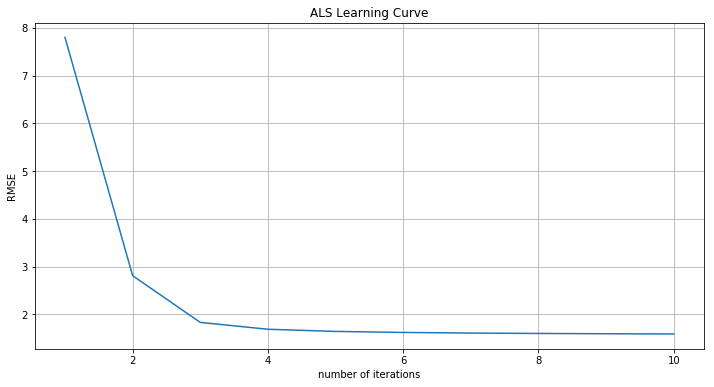

In [92]:

# create an array of num_iters
iter_array = list(range(1, 11))
# create learning curve plot
plot_learning_curve(iter_array, train, validation, 0.2, 8)

In [93]:
# make prediction using test data
test_data = test.map(lambda p: (p[0], p[1]))
predictions = final_model.predictAll(test_data).map(lambda r: ((r[0], r[1]), r[2]))
# get the rating result
ratesAndPreds = test.map(lambda r: ((r[0], r[1]), r[2])).join(predictions)
# get the RMSE
MSE = ratesAndPreds.map(lambda r: (r[1][0] - r[1][1])**2).mean()
error = math.sqrt(MSE)
print('The out-of-sample RMSE of rating predictions is', round(error, 4))

The out-of-sample RMSE of rating predictions is 1.5843


In [0]:
def get_movieID(df_movies, fav_movie_list):
    """
    return all movieID(s) of user's favorite movies
    
    Parameters
    ----------
    df_movies: spark Dataframe, movies data
    
    fav_movie_list: list, user's list of favorite movies
    
    Return
    ------
    movieID_list: list of movieID(s)
    """
    movieID_list = []
    for movie in fav_movie_list:
        movieIDs = df_movies \
            .filter(movies.title.like('%{}%'.format(movie))) \
            .select('movieID') \
            .rdd \
            .map(lambda r: r[0]) \
            .collect()
        movieID_list.extend(movieIDs)
    return list(set(movieID_list))


def add_new_user_to_data(train_data, movieID_list, spark_context):
    """
    add new rows with new user, user's movie and ratings to
    existing train data

    Parameters
    ----------
    train_data: spark RDD, ratings data
    
    movieID_list: list, list of movieID(s)

    spark_context: Spark Context object
    
    Return
    ------
    new train data with the new user's rows
    """
    # get new user id
    new_id = train_data.map(lambda r: r[0]).max() + 1
    # get max rating
    max_rating = train_data.map(lambda r: r[2]).max()
    # create new user rdd
    user_rows = [(new_id, movieID, max_rating) for movieID in movieID_list]
    new_rdd = spark_context.parallelize(user_rows)
    # return new train data
    return train_data.union(new_rdd)
  
def get_inference_data(train_data, df_movies, movieID_list):
    """
    return a rdd with the userid and all movies (except ones in movieID_list)

    Parameters
    ----------
    train_data: spark RDD, ratings data

    df_movies: spark Dataframe, movies data
    
    movieID_list: list, list of movieID(s)

    Return
    ------
    inference data: Spark RDD
    """
    # get new user id
    new_id = train_data.map(lambda r: r[0]).max() + 1
    # return inference rdd
    return df_movies.rdd \
        .map(lambda r: r[0]) \
        .distinct() \
        .filter(lambda x: x not in movieID_list) \
        .map(lambda x: (new_id, x))

def make_recommendation(best_model_params, ratings_data, df_movies, 
                        fav_movie_list, n_recommendations, spark_context):
    """
    return top n movie recommendation based on user's input list of favorite movies


    Parameters
    ----------
    best_model_params: dict, {'iterations': iter, 'rank': rank, 'lambda_': reg}

    ratings_data: spark RDD, ratings data

    df_movies: spark Dataframe, movies data

    fav_movie_list: list, user's list of favorite movies

    n_recommendations: int, top n recommendations

    spark_context: Spark Context object

    Return
    ------
    list of top n movie recommendations
    """
    # modify train data by adding new user's rows
    movieID_list = get_movieID(df_movies, fav_movie_list)
    train_data = add_new_user_to_data(ratings_data, movieID_list, spark_context)
    
    # train best ALS
    model = ALS.train(
        ratings=train_data,
        iterations=best_model_params.get('iterations', None),
        rank=best_model_params.get('rank', None),
        lambda_=best_model_params.get('lambda_', None),
        seed=99)
    
    # get inference rdd
    inference_rdd = get_inference_data(ratings_data, df_movies, movieID_list)
    
    # inference
    predictions = model.predictAll(inference_rdd).map(lambda r: (r[1], r[2]))
    
    # get top n movieID
    topn_rows = predictions.sortBy(lambda r: r[1], ascending=False).take(n_recommendations)
    topn_ids = [r[0] for r in topn_rows]
    
    # return movie titles
    return df_movies.filter(movies.movieID.isin(topn_ids)) \
                    .select('title') \
                    .rdd \
                    .map(lambda r: r[0]) \
                    .collect()

In [118]:
my_favorite_movies = ['Iron Man']

# get recommends
recommends = make_recommendation(
    best_model_params={'iterations': 10, 'rank': 20, 'lambda_': 0.05}, 
    ratings_data=rating_data, 
    
    df_movies=movies, 
    fav_movie_list=my_favorite_movies, 
    n_recommendations=10, 
    spark_context=sc)

print('Recommendations for {}:'.format(my_favorite_movies[0]))
for i, title in enumerate(recommends):
    print('{0}: {1}'.format(i+1, title))

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:35245)
Traceback (most recent call last):
  File "/content/spark-2.4.4-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 929, in _get_connection
    connection = self.deque.pop()
IndexError: pop from an empty deque

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/content/spark-2.4.4-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1067, in start
    self.socket.connect((self.address, self.port))
ConnectionRefusedError: [Errno 111] Connection refused


Py4JNetworkError: ignored

In [117]:
my_favorite_movies = ['Mulan']

# get recommends
recommends = make_recommendation(
    best_model_params={'iterations': 10, 'rank': 20, 'lambda_': 0.05}, 
    ratings_data=rating_data, 
    
    df_movies=movies, 
    fav_movie_list=my_favorite_movies, 
    n_recommendations=10, 
    spark_context=sc)

print('Recommendations for {}:'.format(my_favorite_movies))
for i, title in enumerate(recommends):
    print('{0}: {1}'.format(i+1, title))

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:35245)
Traceback (most recent call last):
  File "/content/spark-2.4.4-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 929, in _get_connection
    connection = self.deque.pop()
IndexError: pop from an empty deque

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/content/spark-2.4.4-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1067, in start
    self.socket.connect((self.address, self.port))
ConnectionRefusedError: [Errno 111] Connection refused


Py4JNetworkError: ignored